In [3]:
pip install scikit-learn numpy pandas 

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import sklearn

from sklearn.utils import resample

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger

# import cv2
import pandas as pd
import numpy as np

# import plotly.graph_objs as go
# from plotly.offline import iplot
from matplotlib import pyplot as plt
import seaborn as sns
import os
from PIL import Image
import os
import random
import shutil

2025-02-20 05:18:50.195491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740028730.246732    2588 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740028730.260550    2588 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 05:18:50.384155: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:


# Define the paths to the folders
real_folder = "Deepfake-Data-V1/real"
fake_folder = "Deepfake-Data-V1/fake"

# Get all files in each folder
real_files = os.listdir(real_folder)
fake_files = os.listdir(fake_folder)

# Calculate the minimum number of images
min_count = min(len(real_files), len(fake_files))

# Function to balance a folder by downsampling
def balance_folder(source_folder, file_list, target_count):
    # Shuffle the file list for randomness
    random.shuffle(file_list)
    # Select only the required number of files
    selected_files = file_list[:target_count]
    # Remove excess files
    for file_name in file_list[target_count:]:
        os.remove(os.path.join(source_folder, file_name))
    return selected_files

# Downsample both folders to the minimum count
balanced_real = balance_folder(real_folder, real_files, min_count)
balanced_fake = balance_folder(fake_folder, fake_files, min_count)

print(f"Balanced folders: {len(balanced_real)} images in 'real', {len(balanced_fake)} images in 'fake'")


Balanced folders: 31701 images in 'real', 31701 images in 'fake'


In [3]:


# Define the paths to the folders (after balancing)
real_folder = "Deepfake-Data-V1/real"
fake_folder = "Deepfake-Data-V1/fake"

# Define the parent output directory for splits
parent_output_dir = "training_data"
train_dir = os.path.join(parent_output_dir, "train")
test_dir = os.path.join(parent_output_dir, "test")
val_dir = os.path.join(parent_output_dir, "val")

# Create the output directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Create subdirectories for real and fake classes inside train, test, and val
os.makedirs(os.path.join(train_dir, "real"), exist_ok=True)
os.makedirs(os.path.join(train_dir, "fake"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "real"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "fake"), exist_ok=True)
os.makedirs(os.path.join(val_dir, "real"), exist_ok=True)
os.makedirs(os.path.join(val_dir, "fake"), exist_ok=True)

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Function to split data
def split_data(file_list, train_ratio, val_ratio, test_ratio):
    random.shuffle(file_list)
    total_count = len(file_list)
    
    train_count = int(total_count * train_ratio)
    val_count = int(total_count * val_ratio)
    
    train_files = file_list[:train_count]
    val_files = file_list[train_count:train_count+val_count]
    test_files = file_list[train_count+val_count:]
    
    return train_files, val_files, test_files

# Get balanced files (after balancing)
real_files = balanced_real
fake_files = balanced_fake

# Split the files for both real and fake classes
real_train, real_val, real_test = split_data(real_files, train_ratio, val_ratio, test_ratio)
fake_train, fake_val, fake_test = split_data(fake_files, train_ratio, val_ratio, test_ratio)

# Function to copy files to the appropriate directory
def copy_files(file_list, source_folder, target_folder):
    for file_name in file_list:
        src_path = os.path.join(source_folder, file_name)
        dest_path = os.path.join(target_folder, file_name)
        shutil.copy(src_path, dest_path)

# Copy files to the respective directories
copy_files(real_train, real_folder, os.path.join(train_dir, "real"))
copy_files(fake_train, fake_folder, os.path.join(train_dir, "fake"))
copy_files(real_val, real_folder, os.path.join(val_dir, "real"))
copy_files(fake_val, fake_folder, os.path.join(val_dir, "fake"))
copy_files(real_test, real_folder, os.path.join(test_dir, "real"))
copy_files(fake_test, fake_folder, os.path.join(test_dir, "fake"))

print(f"Data split complete: {len(real_train)} real train, {len(real_val)} real val, {len(real_test)} real test")
print(f"{len(fake_train)} fake train, {len(fake_val)} fake val, {len(fake_test)} fake test")


Data split complete: 22190 real train, 4755 real val, 4756 real test
22190 fake train, 4755 fake val, 4756 fake test


# Training

In [2]:
import tensorflow as tf

# Check if TensorFlow is using the GPU
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("TensorFlow is using the GPU")
else:
    print("TensorFlow is not using the GPU")


2025-01-30 04:48:29.956825: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-30 04:48:30.071002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738212510.127124   24944 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738212510.140168   24944 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-30 04:48:30.256275: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

TensorFlow is using the GPU


In [3]:
tf.get_logger().setLevel('ERROR')
# tf.keras.backend.set_floatx('float64')

In [4]:
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential([
    layers.Conv2D(64, kernel_size=7, padding="same", activation="relu", kernel_initializer="he_normal", input_shape=[224, 224, 3]),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(128, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal"),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(32, activation="relu", kernel_initializer="he_normal"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(16, activation="relu", kernel_initializer="he_normal"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1738212519.447057   24944 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13949 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


run a model.summary here

Found 57804 files belonging to 2 classes.
Found 17595 files belonging to 2 classes.
Epoch 1/30
904/904 ━━━━━━━━━━━━━━━━━━━━ 106s 117ms/step - accuracy: 0.8125 - loss: 0.3821 - val_accuracy: 0.8359 - val_loss: 0.3511
Epoch 2/30
904/904 ━━━━━━━━━━━━━━━━━━━━ 108s 119ms/step - accuracy: 0.8156 - loss: 0.3761 - val_accuracy: 0.8395 - val_loss: 0.3514
Epoch 3/30
904/904 ━━━━━━━━━━━━━━━━━━━━ 108s 119ms/step - accuracy: 0.8154 - loss: 0.3714 - val_accuracy: 0.8399 - val_loss: 0.3499
Epoch 4/30
904/904 ━━━━━━━━━━━━━━━━━━━━ 108s 119ms/step - accuracy: 0.8173 - loss: 0.3693 - val_accuracy: 0.8401 - val_loss: 0.3466
Epoch 5/30
904/904 ━━━━━━━━━━━━━━━━━━━━ 108s 119ms/step - accuracy: 0.8207 - loss: 0.3691 - val_accuracy: 0.8439 - val_loss: 0.3402
Epoch 6/30
904/904 ━━━━━━━━━━━━━━━━━━━━ 107s 119ms/step - accuracy: 0.8223 - loss: 0.3628 - val_accuracy: 0.8471 - val_loss: 0.3353
Epoch 7/30
904/904 ━━━━━━━━━━━━━━━━━━━━ 108s 119ms/step - accuracy: 0.8244 - loss: 0.3575 - val_accuracy: 0.8518 - val_loss:

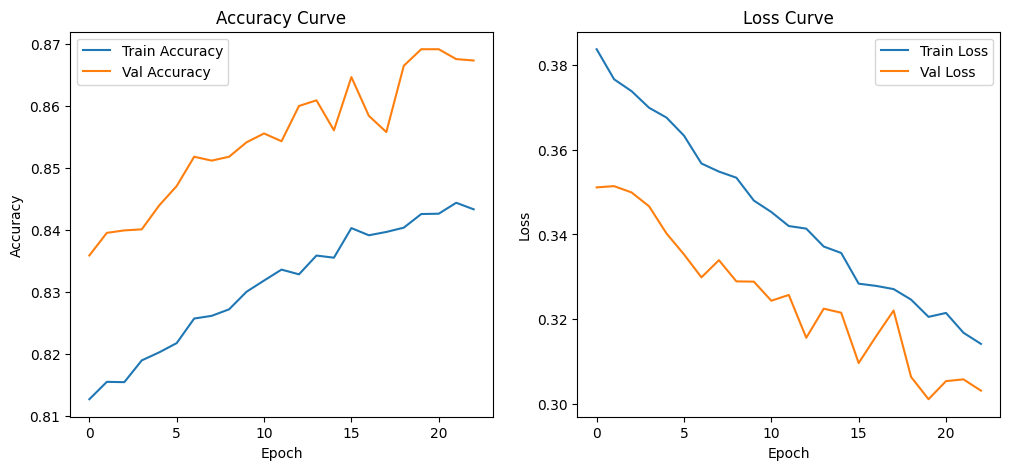

In [4]:
import tensorflow as tf

# Define directory paths
train_dir = "training_data/train"
val_dir = "training_data/val"

# Load datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),  # Resize images to 224x224
    batch_size=64,  # Load in batches
    label_mode='binary'  # Binary classification: "real" vs. "fake"
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=64,
    label_mode='binary'
)

# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Prefetch for improved performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor="val_loss",  # Stop when validation loss stops improving
    patience=3,  # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the best model weights
)

# Logging to a CSV file
csv_logger = CSVLogger("training_log_CNN.csv", append=False)  # Overwrite previous logs

# Train the model with callbacks
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[early_stopping, csv_logger]  # Add callbacks here
)

model.save("CNN_from_scratch.h5")  # Saves the model in HDF5 format

# Load the logged data
log_data = pd.read_csv("training_log_CNN.csv")

# Plot accuracy and loss curves
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
ax[0].plot(log_data["epoch"], log_data["accuracy"], label="Train Accuracy")
ax[0].plot(log_data["epoch"], log_data["val_accuracy"], label="Val Accuracy")
ax[0].set_title("Accuracy Curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend()

# Loss plot
ax[1].plot(log_data["epoch"], log_data["loss"], label="Train Loss")
ax[1].plot(log_data["epoch"], log_data["val_loss"], label="Val Loss")
ax[1].set_title("Loss Curve")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend()

plt.show()



# Try transfer learning next

In [10]:
import tensorflow as tf

# Define directory paths
train_dir = "training_data/train"
val_dir = "training_data/val"

# Load datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),  # Resize images to 224x224
    batch_size=64,  # Load in batches
    label_mode='binary'  # Binary classification: "real" vs. "fake"
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=64,
    label_mode='binary'
)

print(train_dataset.class_names)  # Check assigned class labels
# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Prefetch for improved performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))


Found 57804 files belonging to 2 classes.
Found 17595 files belonging to 2 classes.
['fake', 'real']


Epoch 1/30


I0000 00:00:1738236623.569027    3489 service.cc:148] XLA service 0x7f9cb4001fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738236623.569344    3489 service.cc:156]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-01-30 11:30:23.657302: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738236624.323580    3489 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-30 11:30:25.654825: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6295', 496 bytes spill stores, 496 bytes spill loads

2025-01-30 11:30:25.654887: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4256', 220 bytes spill stor

  2/904 ━━━━━━━━━━━━━━━━━━━━ 1:17 86ms/step - accuracy: 0.4219 - loss: 0.7354  

I0000 00:00:1738236637.609697    3489 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


903/904 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6672 - loss: 0.6212

2025-01-30 11:33:10.885348: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4256_0', 8 bytes spill stores, 8 bytes spill loads



904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.6672 - loss: 0.6212

2025-01-30 11:33:40.904501: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1021_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-30 11:33:41.134197: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1021', 4 bytes spill stores, 4 bytes spill loads

2025-01-30 11:33:41.255656: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1021', 224 bytes spill stores, 224 bytes spill loads

E0000 00:00:1738236828.171987    3489 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1738236828.290432    3489 gpu_timer.cc:82] Delay kernel timed out: measured time has 

904/904 ━━━━━━━━━━━━━━━━━━━━ 211s 214ms/step - accuracy: 0.6672 - loss: 0.6212 - val_accuracy: 0.7020 - val_loss: 0.5711
Epoch 2/30
904/904 ━━━━━━━━━━━━━━━━━━━━ 108s 120ms/step - accuracy: 0.6973 - loss: 0.5832 - val_accuracy: 0.7174 - val_loss: 0.5496
Epoch 3/30
904/904 ━━━━━━━━━━━━━━━━━━━━ 108s 119ms/step - accuracy: 0.7109 - loss: 0.5635 - val_accuracy: 0.7259 - val_loss: 0.5334
Epoch 4/30
904/904 ━━━━━━━━━━━━━━━━━━━━ 107s 118ms/step - accuracy: 0.7186 - loss: 0.5523 - val_accuracy: 0.7325 - val_loss: 0.5224
Epoch 5/30
904/904 ━━━━━━━━━━━━━━━━━━━━ 108s 119ms/step - accuracy: 0.7263 - loss: 0.5419 - val_accuracy: 0.7416 - val_loss: 0.5154
Epoch 6/30
904/904 ━━━━━━━━━━━━━━━━━━━━ 108s 119ms/step - accuracy: 0.7318 - loss: 0.5302 - val_accuracy: 0.7456 - val_loss: 0.5038
Epoch 7/30
904/904 ━━━━━━━━━━━━━━━━━━━━ 107s 119ms/step - accuracy: 0.7355 - loss: 0.5232 - val_accuracy: 0.7504 - val_loss: 0.4999
Epoch 8/30
904/904 ━━━━━━━━━━━━━━━━━━━━ 108s 119ms/step - accuracy: 0.7384 - loss: 0.51

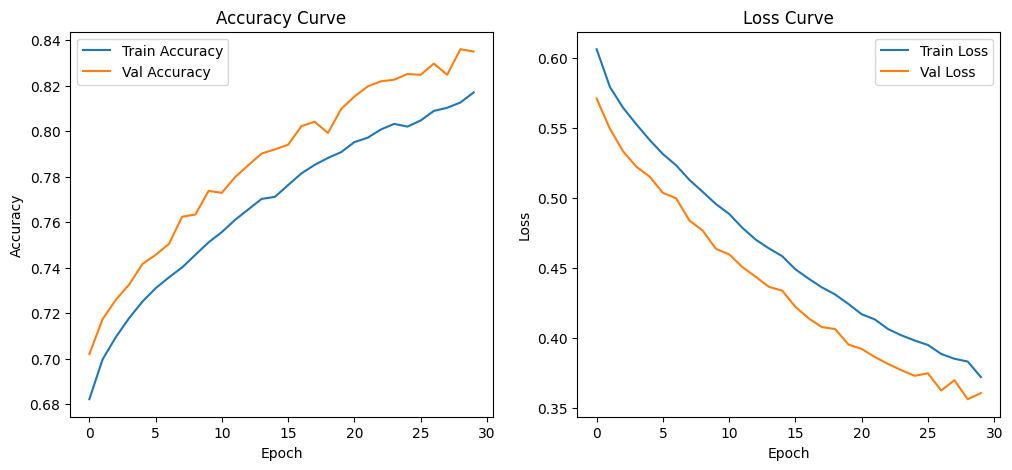

In [3]:
# Load pre-trained Xception model
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Freeze the base model
base_model.trainable = False

# Add custom layers
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(
    monitor="val_loss",  # Stop when validation loss stops improving
    patience=3,  # Wait for 3 epochs before stopping
    restore_best_weights=True  # Keep the best model weights
)

csv_logger = CSVLogger("training_log_X_V2.csv", append=False)  # Overwrite previous logs

# Train the model
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[early_stopping, csv_logger]  # Add callbacks here
)

# Save the trained model
model.save("xception_TL_model.h5")

# Load the logged data
log_data = pd.read_csv("training_log_X_V2.csv")

# Plot accuracy and loss curves
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
ax[0].plot(log_data["epoch"], log_data["accuracy"], label="Train Accuracy")
ax[0].plot(log_data["epoch"], log_data["val_accuracy"], label="Val Accuracy")
ax[0].set_title("Accuracy Curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend()

# Loss plot
ax[1].plot(log_data["epoch"], log_data["loss"], label="Train Loss")
ax[1].plot(log_data["epoch"], log_data["val_loss"], label="Val Loss")
ax[1].set_title("Loss Curve")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend()

plt.show()

In [7]:
import pandas as pd

# Create a dictionary with the epoch and corresponding values
data = {
    'epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    'accuracy': [0.6672, 0.6973, 0.7109, 0.7186, 0.7263, 0.7318, 0.7355, 0.7384, 0.7468, 0.7530, 0.7577, 0.7602, 0.7662, 0.7687, 0.7703, 0.7761, 0.7815, 0.7855, 0.7908, 0.7912, 0.7978, 0.7973, 0.8024, 0.8024, 0.8033, 0.8044, 0.8109, 0.8089, 0.8138, 0.8185],
    'loss': [0.6212, 0.5832, 0.5635, 0.5523, 0.5419, 0.5302, 0.5232, 0.5140, 0.5032, 0.4942, 0.4866, 0.4787, 0.4693, 0.4637, 0.4562, 0.4480, 0.4427, 0.4358, 0.4294, 0.4238, 0.4139, 0.4123, 0.4049, 0.4029, 0.3961, 0.3956, 0.3853, 0.3865, 0.3822, 0.3711],
    'val_accuracy': [0.7020, 0.7174, 0.7259, 0.7325, 0.7416, 0.7456, 0.7504, 0.7624, 0.7633, 0.7737, 0.7729, 0.7798, 0.7851, 0.7902, 0.7920, 0.7940, 0.8022, 0.8041, 0.7992, 0.8097, 0.8152, 0.8197, 0.8219, 0.8226, 0.8251, 0.8248, 0.8297, 0.8248, 0.8360, 0.8350],
    'val_loss': [0.5711, 0.5496, 0.5334, 0.5224, 0.5154, 0.5038, 0.4999, 0.4841, 0.4768, 0.4638, 0.4598, 0.4507, 0.4438, 0.4366, 0.4339, 0.4223, 0.4141, 0.4079, 0.4065, 0.3954, 0.3923, 0.3865, 0.3815, 0.3771, 0.3730, 0.3748, 0.3625, 0.3699, 0.3563, 0.3607]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to an Excel file
df.to_csv('training_log_X_V2.csv', index=False)

print("Excel file created!")


Excel file created!


In [7]:
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
print(len(base_model.layers))


132


Transfer learning with optimization

Epoch 1/10
904/904 ━━━━━━━━━━━━━━━━━━━━ 115s 122ms/step - accuracy: 0.6635 - loss: 0.6232 - val_accuracy: 0.7084 - val_loss: 0.5687
Epoch 2/10
904/904 ━━━━━━━━━━━━━━━━━━━━ 108s 119ms/step - accuracy: 0.6980 - loss: 0.5806 - val_accuracy: 0.7111 - val_loss: 0.5558
Epoch 3/10
904/904 ━━━━━━━━━━━━━━━━━━━━ 108s 119ms/step - accuracy: 0.7096 - loss: 0.5671 - val_accuracy: 0.7284 - val_loss: 0.5339
Epoch 4/10
904/904 ━━━━━━━━━━━━━━━━━━━━ 107s 119ms/step - accuracy: 0.7173 - loss: 0.5549 - val_accuracy: 0.7283 - val_loss: 0.5270
Epoch 5/10
904/904 ━━━━━━━━━━━━━━━━━━━━ 107s 118ms/step - accuracy: 0.7226 - loss: 0.5435 - val_accuracy: 0.7417 - val_loss: 0.5114
Epoch 6/10
904/904 ━━━━━━━━━━━━━━━━━━━━ 108s 119ms/step - accuracy: 0.7286 - loss: 0.5320 - val_accuracy: 0.7404 - val_loss: 0.5067
Epoch 7/10
904/904 ━━━━━━━━━━━━━━━━━━━━ 108s 119ms/step - accuracy: 0.7374 - loss: 0.5217 - val_accuracy: 0.7495 - val_loss: 0.4924
Epoch 8/10
904/904 ━━━━━━━━━━━━━━━━━━━━ 108s 119ms/step - accuracy: 0.7391 -

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_697
Received: inputs=('Tensor(shape=(32, 224, 224, 3))', 'Tensor(shape=(32, 1))')
  warnings.warn(msg)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
Epoch 1/20
904/904 ━━━━━━━━━━━━━━━━━━━━ 220s 224ms/step - accuracy: 0.7283 - loss: 0.5399 - val_accuracy: 0.8979 - val_loss: 0.2497
Epoch 2/20
904/904 ━━━━━━━━━━━━━━━━━━━━ 195s 216ms/step - accuracy: 0.8949 - loss: 0.2487 - val_accuracy: 0.9423 - val_loss: 0.1665
Epoch 3/20
904/904 ━━━━━━━━━━━━━━━━━━━━ 195s 215ms/step - accuracy: 0.9545 - loss: 0.1171 - val_accuracy: 0.9616 - val_loss: 0.1172
Epoch 4/20
904/904 ━━━━━━━━━━━━━━━━━━━━ 194s 215ms/step - accuracy: 0.9745 - loss: 0.0706 - val_accuracy: 0.9606 - val_loss: 0.1196
Epoch 5/20
904/904 ━━━━━━━━━━━━━━━━━━━━ 195s 216ms/step - accuracy: 0.9811 - loss: 0.0530 - val_accuracy: 0.9596 - val_loss: 0.1348
Epoch 6/20
904/904 ━━━━━━━━━━━━━━━━━━━━ 195s 216ms/step - accuracy: 0.9830 - loss: 0.0489 - val_accuracy: 0.9706 - val_loss: 0.1044
Epoch 7/20
904/904 ━━━━━━━━━━━━━━━━━━━━ 195s 216ms/step - accuracy: 0.9865 - loss: 0.0398 - val_accuracy: 0.9719 - val_loss: 0.1119
Epoch 8/20
904/904 ━━━━━━━━━━━━━━━━━━━

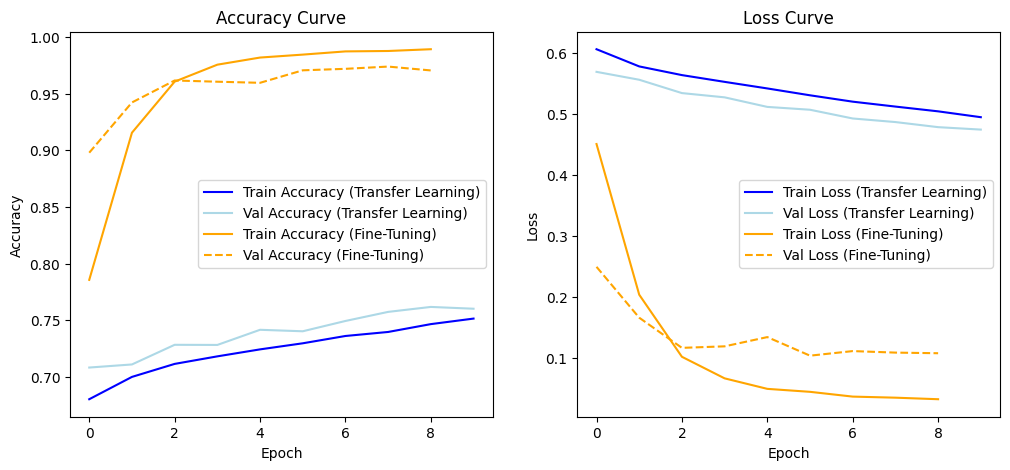

In [9]:

# Load pre-trained Xception model
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Initially freeze the base model
base_model.trainable = False

# Add custom layers
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model (initial training phase)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for transfer learning phase
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
csv_logger_transfer = CSVLogger("training_log_transfer_learning.csv", append=False)

# Train the model with frozen base model (transfer learning phase)
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[early_stopping, csv_logger_transfer])

# **Unfreeze the base model for fine-tuning**
base_model.trainable = True

# Optionally, freeze some early layers (e.g., first 50)
for layer in base_model.layers[:50]:  
    layer.trainable = False

# Recompile with a **lower learning rate**
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Warm-up step to prevent GPU timing issues
warmup_batch = next(iter(train_dataset))  # Get a batch from the dataset
_ = model.predict(warmup_batch)  # Run a prediction to initialize the model on GPU

# Callbacks for fine-tuning phase
csv_logger_fine_tune = CSVLogger("training_log_fine_tuning.csv", append=False)

# Continue training with fine-tuning
history_fine = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[early_stopping, csv_logger_fine_tune])

# Save the fine-tuned model
model.save("xception_finetuned.h5")

# Load the logged data for transfer learning
log_data_transfer = pd.read_csv("training_log_transfer_learning.csv")

# Load the logged data for fine-tuning
log_data_fine_tune = pd.read_csv("training_log_fine_tuning.csv")

# Plot accuracy and loss curves for both transfer learning and fine-tuning phases on the same graph
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot for both transfer learning and fine-tuning
ax[0].plot(log_data_transfer["epoch"], log_data_transfer["accuracy"], label="Train Accuracy (Transfer Learning)", color="blue")
ax[0].plot(log_data_transfer["epoch"], log_data_transfer["val_accuracy"], label="Val Accuracy (Transfer Learning)", color="lightblue")
ax[0].plot(log_data_fine_tune["epoch"], log_data_fine_tune["accuracy"], label="Train Accuracy (Fine-Tuning)", color="orange")
ax[0].plot(log_data_fine_tune["epoch"], log_data_fine_tune["val_accuracy"], label="Val Accuracy (Fine-Tuning)", color="orange", linestyle='--')
ax[0].set_title("Accuracy Curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend()

# Loss plot for both transfer learning and fine-tuning
ax[1].plot(log_data_transfer["epoch"], log_data_transfer["loss"], label="Train Loss (Transfer Learning)", color="blue")
ax[1].plot(log_data_transfer["epoch"], log_data_transfer["val_loss"], label="Val Loss (Transfer Learning)", color="lightblue")
ax[1].plot(log_data_fine_tune["epoch"], log_data_fine_tune["loss"], label="Train Loss (Fine-Tuning)", color="orange")
ax[1].plot(log_data_fine_tune["epoch"], log_data_fine_tune["val_loss"], label="Val Loss (Fine-Tuning)", color="orange", linestyle='--')
ax[1].set_title("Loss Curve")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend()

plt.show()

# Comparison

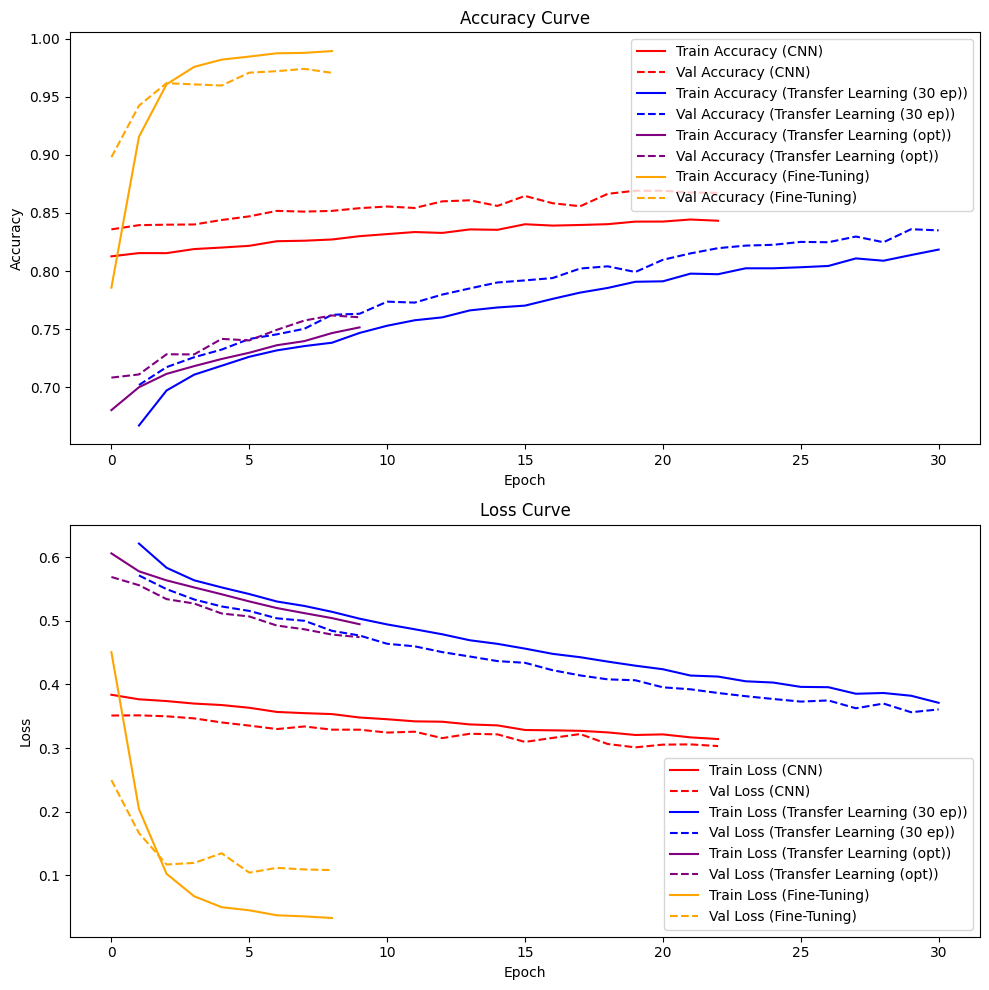

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training logs
log_files = {
    "CNN": "training_log_CNN.csv",
    "Transfer Learning (30 ep)": "training_log_X_V2.csv",
    "Transfer Learning (opt)": "training_log_transfer_learning.csv",
    "Fine-Tuning": "training_log_fine_tuning.csv",
}

logs = {name: pd.read_csv(file) for name, file in log_files.items()}

# Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Colors for each model
colors = {
    "CNN": "red",
    "Transfer Learning (30 ep)": "blue",
    "Transfer Learning (opt)": "purple",
    "Fine-Tuning": "orange",
}

# Plot accuracy curves
for name, data in logs.items():
    ax[0].plot(data["epoch"], data["accuracy"], label=f"Train Accuracy ({name})", color=colors[name])
    ax[0].plot(data["epoch"], data["val_accuracy"], label=f"Val Accuracy ({name})", color=colors[name], linestyle='--')

ax[0].set_title("Accuracy Curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend()

# Plot loss curves
for name, data in logs.items():
    ax[1].plot(data["epoch"], data["loss"], label=f"Train Loss ({name})", color=colors[name])
    ax[1].plot(data["epoch"], data["val_loss"], label=f"Val Loss ({name})", color=colors[name], linestyle='--')

ax[1].set_title("Loss Curve")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend()

plt.tight_layout()
plt.show()


I chose the **Transfer Learning model trained for 30 epochs** over the CNN and Transfer Learning with optimization due to its **smaller size** and **better real-time performance**. 

- At **80MB**, it’s the smallest model, while the **Transfer Learning with optimization** is **240MB**, and the **CNN from scratch** is **450MB**.
- Larger models are slower and more resource-intensive, making them less suitable for **real-time detection**.
- The **30-epoch Transfer Learning model** strikes the best balance between **size, efficiency**, and **speed for deployment**, while still achieving the target **80% accuracy**.

**Early stopping** was used, which is why some models were trained for fewer epochs compared to others.


# Selected model: Xception Model

### Parameters

- **Base Model**: Xception (pre-trained on ImageNet)
  - **include_top=False**: Excludes the fully connected layers of the model.
  - **weights='imagenet'**: Uses pre-trained weights from ImageNet.
  - **input_shape=(224, 224, 3)**: Input image size is set to 224x224 with 3 color channels (RGB).

### Base Model Freezing
- **base_model.trainable = False**: Freezes the weights of the base model so that they are not updated during training.

### Custom Layers
- **GlobalAveragePooling2D()**: A pooling layer that reduces each feature map to a single value (average) to flatten the output.
- **Dense(128, activation='relu')**: Fully connected layer with 128 units and ReLU activation.
- **Dropout(0.5)**: Dropout layer to prevent overfitting, with a 50% dropout rate.
- **Dense(1, activation='sigmoid')**: Output layer for binary classification (1 output unit with sigmoid activation).

### Compilation Parameters
- **Optimizer**: adam - Adaptive moment estimation optimizer, commonly used in deep learning for faster convergence.
- **Loss Function**: binary_crossentropy - Used for binary classification tasks.
- **Metrics**: accuracy - Tracks the accuracy of the model during training.

### Callbacks

- **EarlyStopping**:
  - **monitor="val_loss"**: Monitors validation loss for stopping criteria.
  - **patience=3**: Waits for 3 epochs before stopping training if no improvement is seen.
  - **restore_best_weights=True**: Restores the weights from the epoch with the best validation loss.

- **CSVLogger**:
  - **CSVLogger("training_log_X_V2.csv", append=False)**: Logs the training history to a CSV file, overwriting previous logs.

### Others
- **Epochs**: 30 - The model is set to train for a maximum of 30 epochs.
- **Batch Size**: 64.


### Test the model on some images

In [6]:
# Load the pre-trained model
from PIL import Image
import tensorflow as tf
import numpy as np
model = tf.keras.models.load_model('xception_TL_model.h5')

def preprocess_image(image_path):
    # Open the image using Pillow
    image = Image.open(image_path)
    
    # Resize the image to match the input size of the model (224x224 for Xception)
    image = image.resize((224, 224))
    
    # Convert image to numpy array and normalize
    image_np = np.array(image) / 255.0  # Normalize to [0, 1]
    
    # Add batch dimension (model expects a batch of images)
    image_batch = np.expand_dims(image_np, axis=0)
    
    return image_batch

# Load and preprocess the image
image_path = 'training_data/val/real/ymprxvokzn.jpg'  # Provide your image path here
processed_image = preprocess_image(image_path)

# Run inference
predictions = model.predict(processed_image)

# Print the predictions (depending on the model, this may output probabilities or class labels)
print("Predictions:", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
Predictions: [[0.9996683]]


In [14]:
# Get the last layer of the model
last_layer = model.layers[-1]

# Check the activation function
print(f"Activation function of the last layer: {last_layer.activation}")

# Check the weights and biases
weights, biases = last_layer.get_weights()
print(f"Last layer weights: {weights}")

print(f"Last layer biases: {biases}")

Activation function of the last layer: <function sigmoid at 0x7f57261fe0e0>
Last layer weights: [[ 0.38372526]
 [-0.24368533]
 [ 0.619279  ]
 [-0.11823323]
 [ 0.6443145 ]
 [-0.30930576]
 [-0.1284543 ]
 [-0.03191058]
 [-0.44834474]
 [-0.52057856]
 [-0.39565337]
 [ 0.49023017]
 [-0.33992285]
 [-0.34407273]
 [-0.340437  ]
 [-0.35818213]
 [-0.7701945 ]
 [ 0.6124217 ]
 [ 0.51898825]
 [-0.18576877]
 [ 0.42024013]
 [ 0.6724725 ]
 [-0.06076238]
 [-0.06430257]
 [ 0.59310937]
 [-0.51844007]
 [ 0.19722825]
 [ 0.60967785]
 [-0.4712511 ]
 [ 0.574256  ]
 [-0.7919503 ]
 [ 0.56994975]
 [ 0.535393  ]
 [-0.4408152 ]
 [-0.16873898]
 [-0.15332456]
 [ 0.43504855]
 [ 0.5801137 ]
 [ 0.5571128 ]
 [ 0.6154012 ]
 [ 0.1743655 ]
 [ 0.53631276]
 [ 0.0102751 ]
 [-0.34322658]
 [-0.36249378]
 [ 0.32508057]
 [-0.4431189 ]
 [ 0.20554347]
 [-0.50511444]
 [-0.2479931 ]
 [ 0.5187448 ]
 [-0.03958218]
 [ 0.46290398]
 [ 0.5036598 ]
 [-0.14321516]
 [ 0.5511076 ]
 [-0.15240002]
 [ 0.10031543]
 [-0.18339604]
 [-0.1295607 ]
 [-0

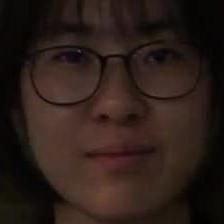

In [13]:
from PIL import Image

# Open the image
img = Image.open(image_path)

# Display the image
img.show()


In [10]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,745,133 (216.47 MB)

 Trainable params: 17,810,625 (67.94 MB)

 Non-trainable params: 3,313,256 (12.64 MB)

 Optimizer params: 35,621,252 (135.88 MB)

In [11]:
print(base_model.output.shape)


(None, 7, 7, 2048)


# Tuning

In [20]:
# define data 
# Define directory paths
train_dir = "training_data/train"
val_dir = "training_data/val"

# Load datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),  # Resize images to 224x224
    batch_size=32,  # Load in batches
    label_mode='binary'  # Binary classification: "real" vs. "fake"
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='binary'
)


Found 57804 files belonging to 2 classes.
Found 17595 files belonging to 2 classes.


Modify Model to Accept Hyperparameters

In [21]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from tensorflow.keras import regularizers

def build_model(hp):
    # Load base model
    base_model = Xception(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    
    # Initially freeze the model
    base_model.trainable = False

    # Custom head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(
            128,  # Keep this fixed as well
            activation="relu",
            kernel_regularizer=regularizers.l1_l2(
                l1=hp.Float("l1_reg", min_value=1e-5, max_value=1e-2, sampling="LOG"),
                l2=hp.Float("l2_reg", min_value=1e-5, max_value=1e-2, sampling="LOG")
            )
        ),
        layers.Dropout(hp.Float("dropout", min_value=0.2, max_value=0.6, step=0.1)),
        layers.Dense(1, activation="sigmoid")
    ])

    # Compile model with tunable learning rate
    model.compile(
        optimizer=optimizers.Adam(hp.Choice("learning_rate", [1e-4, 1e-3, 1e-2])),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model


 Define Tuner

In [27]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=6,  # Try 5 different hyperparameter sets
    executions_per_trial=1,  # Average over 1 run
    directory="hyperparam_tuning",
    project_name="deepfake_classifier"
)

early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

tuner.search(train_dataset, epochs=5, validation_data=val_dataset, callbacks=[early_stopping])

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")


Trial 5 Complete [00h 08m 39s]
val_accuracy: 0.6874680519104004

Best val_accuracy So Far: 0.6874680519104004
Total elapsed time: 00h 42m 20s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
0.00034693        |4.8389e-05        |l1_reg
0.0016427         |8.8189e-05        |l2_reg
0.4               |0.3               |dropout
0.0001            |0.0001            |learning_rate

Epoch 1/5
1807/1807 ━━━━━━━━━━━━━━━━━━━━ 110s 58ms/step - accuracy: 0.5823 - loss: 3.3835 - val_accuracy: 0.6655 - val_loss: 1.1974
Epoch 2/5
1807/1807 ━━━━━━━━━━━━━━━━━━━━ 102s 56ms/step - accuracy: 0.6406 - loss: 1.1406 - val_accuracy: 0.6721 - val_loss: 0.9616
Epoch 3/5
1807/1807 ━━━━━━━━━━━━━━━━━━━━ 102s 56ms/step - accuracy: 0.6505 - loss: 0.9424 - val_accuracy: 0.6739 - val_loss: 0.8374
Epoch 4/5
1413/1807 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.6582 - loss: 0.8345

Fine-Tune Best Model

In [ ]:
# Get the best hyperparameters from the tuner
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters

# Build model with best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Unfreeze the base model layers for fine-tuning
base_model = best_model.layers[0]  # Extract base model from the fine-tuned model
base_model.trainable = True

# Optionally freeze early layers (e.g., keeping the first 50 layers frozen)
for layer in base_model.layers[:50]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fit the model for further training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_fine = best_model.fit(
    train_dataset, 
    epochs=20, 
    validation_data=val_dataset, 
    callbacks=[early_stopping]
)

# Save the best fine-tuned model
best_model.save("xception_finetuned_best.h5")

Epoch 1/20


KeyboardInterrupt: 

# Model explainability

In [1]:
import tensorflow as tf

# Load your transfer learning model
model = tf.keras.models.load_model("xception_TL_model.h5")


2025-02-16 10:33:25.403429: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-16 10:33:25.941828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739702006.147384    2263 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739702006.213405    2263 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 10:33:26.774397: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [11]:
!pip install shap LIME

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 162.4 MB/s eta 0:00:00
  Created wheel for LIME: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=2c3b3f8f4b09942616c6b4d1c3fc52e6697696bd440ee365303334e6302610be
  Stored in directory: /home/zeus/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built LIME

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

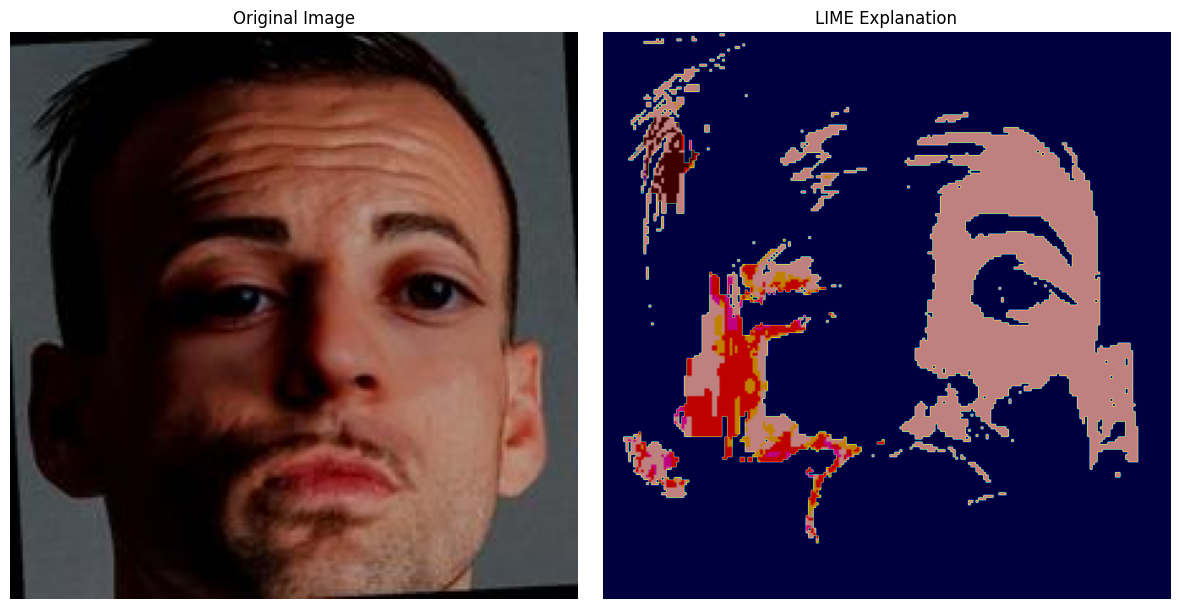

In [15]:
import numpy as np
import lime
from lime import lime_image
from skimage.segmentation import slic
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Define the model prediction function for LIME
def predict_fn(images):
    images = np.array(images)  # Ensure the images are in the correct format
    images = images / 255.0  # Normalize the images to [0, 1]
    return model.predict(images)

# Load and preprocess an image
image_path = 'training_data/test/fake/16904.jpg'
img = image.load_img(image_path, target_size=(224, 224))  # Resize image to match model input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Create the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Generate superpixels for LIME
explanation = explainer.explain_instance(img_array[0], 
                                         predict_fn, 
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)

# Get the explanation for the top predicted class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, 
                                            num_features=10, 
                                            hide_rest=True)

# Set up the subplot to show both images side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original image
ax[0].imshow(img)  # Show the original image
ax[0].set_title("Original Image")
ax[0].axis('off')  # Hide axes

# Image with explanation overlay
ax[1].imshow(temp)  # Show the image with LIME explanation
ax[1].imshow(mask, cmap='jet', alpha=0.5)  # Overlay the mask on the image
ax[1].set_title("LIME Explanation")
ax[1].axis('off')  # Hide axes

plt.tight_layout()
plt.show()


Dark Red Areas: These areas highlight the regions that have the most negative influence towards the "fake" class. In simpler terms, these are the parts of the image that the model "sees" as the strongest indicators of the image being a deepfake.

In [8]:
for layer in model.layers:
    print(layer.name)


xception
global_average_pooling2d_2
dense_4
dropout_2
dense_5


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,123,883 (80.58 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 2 (12.00 B)

In [ ]:
tf.keras.utils.plot_model(
model,
to_file="model.png",
show_shapes=True,
show_dtype=False,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
layer_range=None,
show_layer_activations=True,
)

## Testing on validation data

In [1]:
import tensorflow as tf

# Load your transfer learning model
# model = tf.keras.models.load_model("xception_finetuned.h5")
model = tf.keras.models.load_model("xception_TL_model.h5")


2025-02-16 07:55:49.805049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739692549.856386    2283 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739692549.874009    2283 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 07:55:49.996368: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1739692553.696066    2283 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20

Found 17596 files belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━

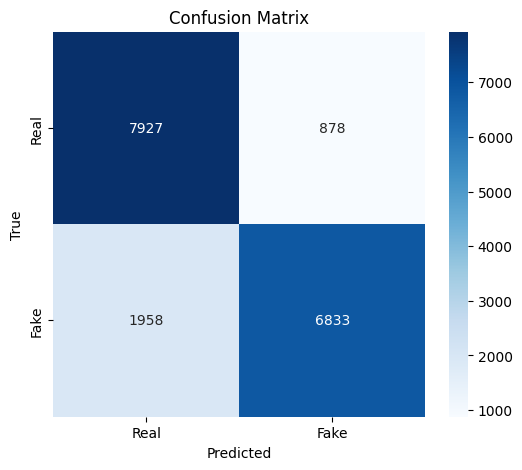

In [21]:
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the model (make sure to load your trained model here)
# model = tf.keras.models.load_model('your_model_path')  # Adjust this as needed

# Make predictions and get true labels
y_true = []
y_pred = []
val_dir = "training_data/test"


val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=64,
    label_mode='binary'
)

normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))



for images, labels in val_dataset:
    # Get model predictions (probabilities)
    predictions = model.predict(images)
    
    # Convert probabilities to binary labels
    y_pred_batch = (predictions > 0.5).astype(int)
    
    # Append true labels and predicted labels
    y_true.extend(labels.numpy())
    y_pred.extend(y_pred_batch)

# Convert lists to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate Precision, Recall, and F1 Score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}') 

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Model Performance Analysis

The high **precision** (88.61%) means the model is reliable when it predicts something as "Real." However, there is some room for improvement in **recall** (77.73%) to ensure fewer "Real" instances are missed.

The **F1-score** is quite good at 0.8281, indicating a solid balance between precision and recall. However, the number of **false negatives** (1958) could be a point of focus to improve recall and, as a result, further boost the F1-score.

### To improve the model's performance:

1. **Increase recall**: Focus on reducing false negatives. This could be achieved by:
   - Adjusting the decision threshold.
   - Using methods like oversampling the minority class.

2. **Improve model robustness**: Try fine-tuning the model to minimize both false positives and false negatives for a more balanced outcome.


Found 17596 files belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━

2025-02-16 08:03:32.028029: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


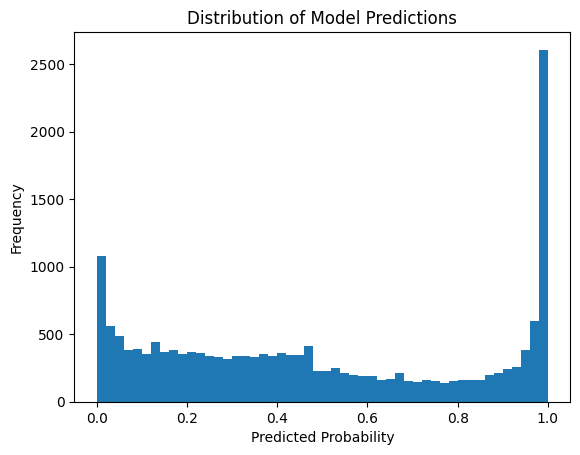

In [9]:
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the model (make sure to load your trained model here)
# model = tf.keras.models.load_model('your_model_path')  # Adjust this as needed

# Make predictions and get true labels
y_true = []
y_scores = []
val_dir = "training_data/test"


val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=64,
    label_mode='binary'
)

normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))



for images, labels in val_dataset:
    # Get model predictions (probabilities)
    predictions = model.predict(images)
    
    # Convert probabilities to binary labels
    y_scores.extend(predictions.flatten())  # Store raw probability scores
    
    # Append true labels and predicted labels
    y_true.extend(labels.numpy())



# Convert to numpy arrays
y_true = np.array(y_true)
y_scores = np.array(y_scores)  # <-- Use y_scores instead of y_pred

plt.hist(y_scores, bins=50)
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Model Predictions")
plt.show()



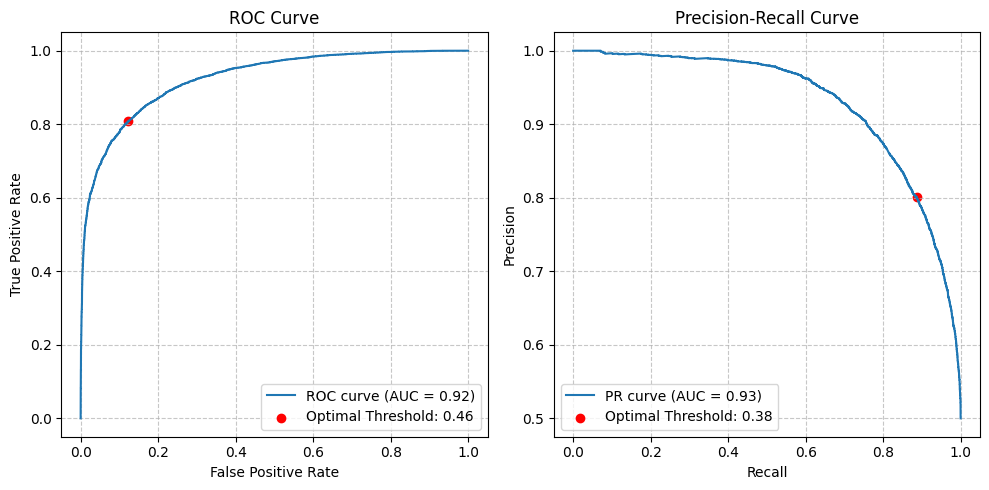

Optimal Threshold (ROC): 0.4637
Optimal Threshold (PR Curve): 0.3802


In [11]:
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Assume y_true and y_scores are already populated from your model's predictions

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Compute the optimal threshold using Youden's J statistic
optimal_idx = np.argmax(tpr - fpr)  # Index of the best threshold
optimal_threshold = thresholds[optimal_idx]

# Plot ROC Curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # First subplot for ROC

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold: {optimal_threshold:.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Compute Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

# Find the optimal threshold for PR curve (closest to (1,1))
pr_optimal_idx = np.argmax(precision + recall - 1)  # Maximizing F1-like balance
pr_optimal_threshold = pr_thresholds[pr_optimal_idx]

# Plot Precision-Recall Curve
plt.subplot(1, 2, 2)  # Second subplot for PR curve

plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.scatter(recall[pr_optimal_idx], precision[pr_optimal_idx], color='red', label=f'Optimal Threshold: {pr_optimal_threshold:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"Optimal Threshold (ROC): {optimal_threshold:.4f}")
print(f"Optimal Threshold (PR Curve): {pr_optimal_threshold:.4f}")


## Threshold Selection and Curve Analysis

### ROC Curve (Threshold = 0.46)

The optimal threshold here is chosen to balance the **True Positive Rate (TPR)** and **False Positive Rate (FPR)**. Since the **ROC curve** is effective for assessing general classification performance, this threshold optimizes the distinction between positive and negative classes.

### PR Curve (Threshold = 0.38)

The **Precision-Recall (PR) Curve** is more useful for dealing with imbalanced datasets. The optimal threshold in this case is chosen to balance **Precision** and **Recall**, which differs from balancing TPR and FPR. Since recall tends to be high at lower thresholds, the PR curve often suggests a lower optimal threshold than ROC.

### Conclusion

Since I want a balanced model, I will be using the **ROC-based threshold (0.46)**.
